In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from IPython.display import display, Markdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/differentiated-thyroid-cancer-recurrence/Thyroid_Diff.csv


In [2]:
!pip install visualkeras


  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/da/05/8912c901a3965ec7117d6cc33eaec3888c717611f72ce69d8be62a01d149/aggdraw-1.3.18-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.6 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("/kaggle/input/differentiated-thyroid-cancer-recurrence/Thyroid_Diff.csv")

# EDA

In [4]:
df.shape

(383, 17)

In [5]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

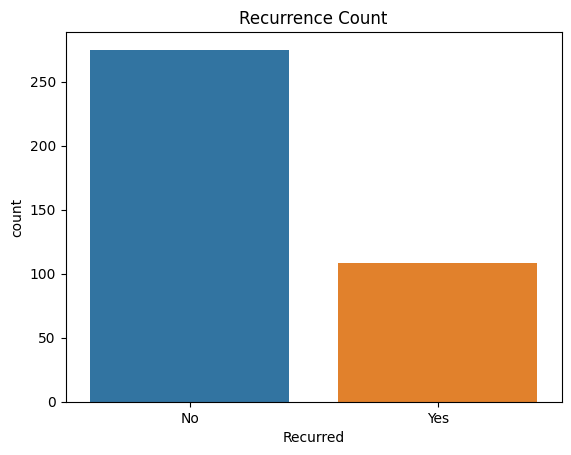

In [7]:
sns.countplot(x='Recurred', data=df)
plt.title('Recurrence Count')
plt.show()

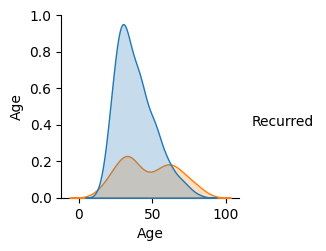

In [8]:
sns.pairplot(df, hue='Recurred')
plt.show()

In [9]:

print(df.columns)


Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')


# Selected features ['Age', 'Smoking', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']

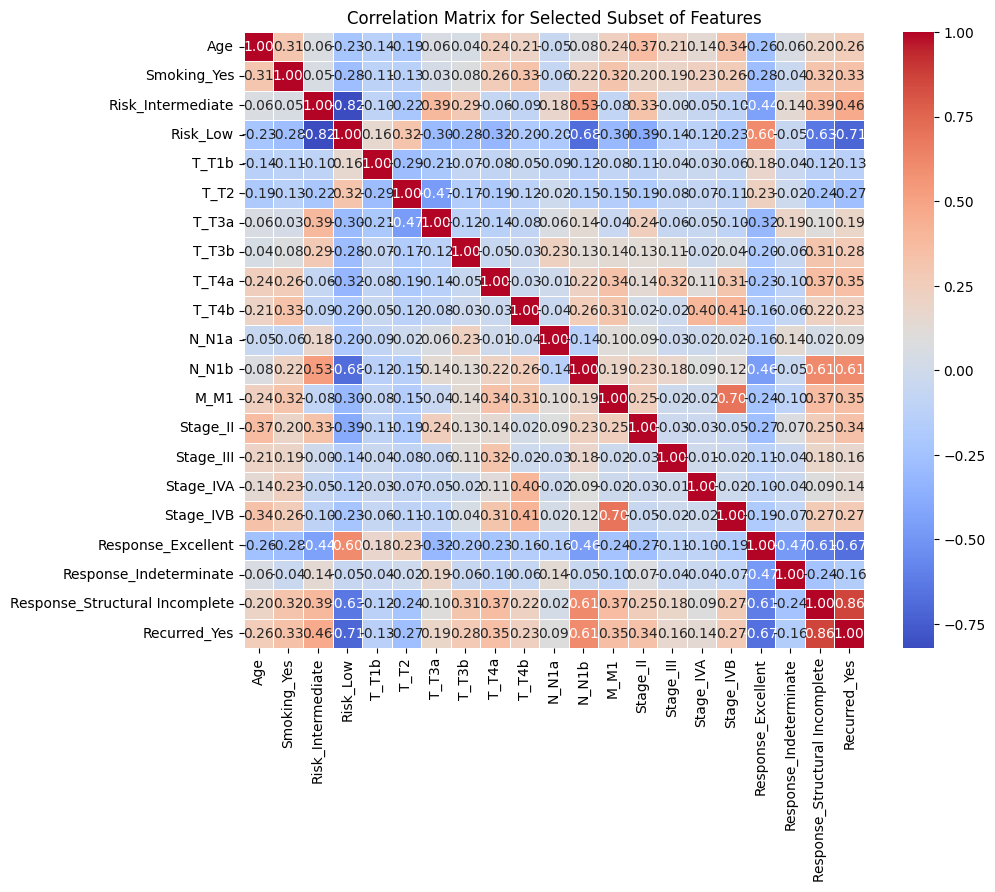

In [10]:
selected_subset = ['Age', 'Smoking', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']


df_subset = pd.get_dummies(df[selected_subset + ['Recurred']], drop_first=True)


correlation_matrix_subset = df_subset.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Selected Subset of Features')
plt.show()

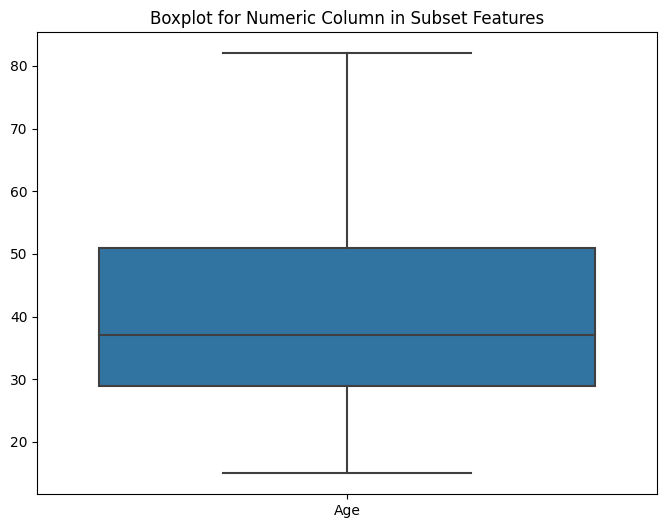

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns_subset = ['Age']


plt.figure(figsize=(8, 6))
sns.boxplot(data=df[numeric_columns_subset])
plt.title('Boxplot for Numeric Column in Subset Features')
plt.show()
# No outliers

## Feature one hot encoding

In [12]:


df_subset_encoded = pd.get_dummies(df[['Age', 'Smoking', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred']], drop_first=True)

X = df_subset_encoded.drop('Recurred_Yes', axis=1).values
y = df_subset_encoded['Recurred_Yes'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# SMOTE Sampling to address Class Imbalances

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

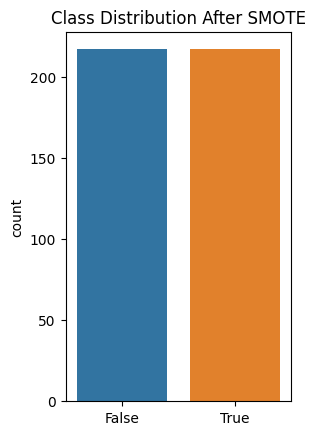

In [14]:
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')

plt.show()

# ANN

In [15]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_resampled.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
55/55 [==============================] - 2s 8ms/step - loss: 0.4269 - accuracy: 0.8571 - val_loss: 0.2395 - val_accuracy: 0.9481
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1900 - accuracy: 0.9401 - val_loss: 0.1187 - val_accuracy: 0.9870
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9608 - val_loss: 0.0841 - val_accuracy: 0.9870
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1045 - accuracy: 0.9608 - val_loss: 0.0680 - val_accuracy: 0.9870
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0908 - accuracy: 0.9677 - val_loss: 0.0593 - val_accuracy: 0.9870
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0797 - accuracy: 0.9700 - val_loss: 0.0536 - val_accuracy: 0.9870
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0739 - accuracy: 0.9654 - val_loss: 0.0488 - val_accuracy: 0.9870
Epoch 8/50
55/55 [==

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3457 (13.50 KB)
Trainable params: 3457 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Accuracy across Epochs

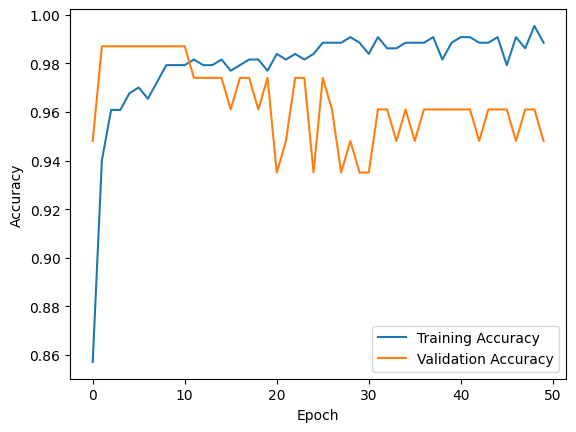

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

3/3 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 0.9481
Test Accuracy: 94.81%


## Accuracy : 94.81%